# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster.

## Prerequisites
This notebook will run under the condition that some simulations have been run, e.g.
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --aug-strategy-train augmentation_with_duplication --aug-nb-train 10 --aug-nb-test 10

```

Have a look at the [README](https://github.com/t-kimber/maxsmi/blob/main/README.md) page for more details.

We are looking to answer these questions:

1. Does augmentation improve performance independently of the model ?
2. How does performance increase with augmentation ? 
3. What is the best augmentation strategy ?
4. Can augmentation help the model learn the inherent symmetry of molecules ?

In [1]:
#  !pip install flake8 pycodestyle_magic
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
from maxsmi.utils_analysis import retrieve_metric, load_results
from maxsmi.utils_smiles import get_num_heavy_atoms
import matplotlib.pyplot as plt

Augmentation grids:
- fine grid: from 1 to 20 (included), with step 1
- coarse grid: from 0 to 100 (included), with step 10
- full grid: from 1 to 20 with step 1 and 20 to 100 with step 10

In [3]:
fine_grid = [elem for elem in range(0, 21, 1)]
coarse_grid = [elem for elem in range(0, 110, 10)]

temp_grid = [elem for elem in range(30, 110, 10)]
full_grid = fine_grid + temp_grid

In [4]:
def plot_metric(metric="r2", set_="test", grid=full_grid):
    """
    Plots the metric of interest on the set of interest.

    Parameters
    ----------
    metric : str, default r2
        The metric of interest, such as the r2 score,
        time or mean squared error.
    set_ : str, default test
        The train set or test set.
    grid : list
        The augmentation number grid.

    Returns
    -------
    None
    """
    tasks = ["ESOL", "free_solv", "lipophilicity"]
    models = ["CONV1D", "CONV2D", "RNN"]

    fig, ax = plt.subplots(nrows=len(tasks),
                           ncols=len(models),
                           figsize=(20, 20))

    for j, model in enumerate(models):
        for i, task in enumerate(tasks):
            legend_ = []
            for augmentation_strategy in [
                "augmentation_with_duplication",
                "augmentation_without_duplication",
                "augmentation_with_reduced_duplication"
            ]:
                x = grid

                y_task_model_strategy = []
                for augmentation_num in grid:
                    try:
                        y = retrieve_metric(
                            metric,
                            set_,
                            task,
                            augmentation_strategy,
                            augmentation_num,
                            augmentation_strategy,
                            augmentation_num,
                            model,
                        )
                    except FileNotFoundError:
                        # print(task, model,
                        #     augmentation_strategy, augmentation_num)
                        y = 0
                    y_task_model_strategy.append(y)
                ax[i, j].plot(x, y_task_model_strategy)
                ax[i, j].set_title(f"{task}:{model}")
                ax[i, j].set_xlabel("Number of augmentation")
                ax[i, j].set_ylabel(f"{metric}")
                if metric == "r2":
                    ax[i, j].set_ylim([0., 1])
                if metric == "rmse" or metric == "mse":
                    ax[i, j].set_ylim([-0.3, 3])
                if grid == full_grid:
                    ax[i, j].set_xticks([elem for elem in range(0, 110, 10)])
                else:
                    ax[i, j].set_xticks(grid)
                caption = f"{augmentation_strategy}"
                legend_.append(caption)
                ax[i, j].legend(legend_)

    fig.suptitle(f"Metric {metric} on {set_} set "
                 f"for all datasets and all models",
                 fontsize=20)
    plt.show()

### 1. Does augmentation improve performance independently of the model?

#### Answer:

Yes. Given the plots below, all types of augmentation are better w.r.t. to no augmentation, for all models.

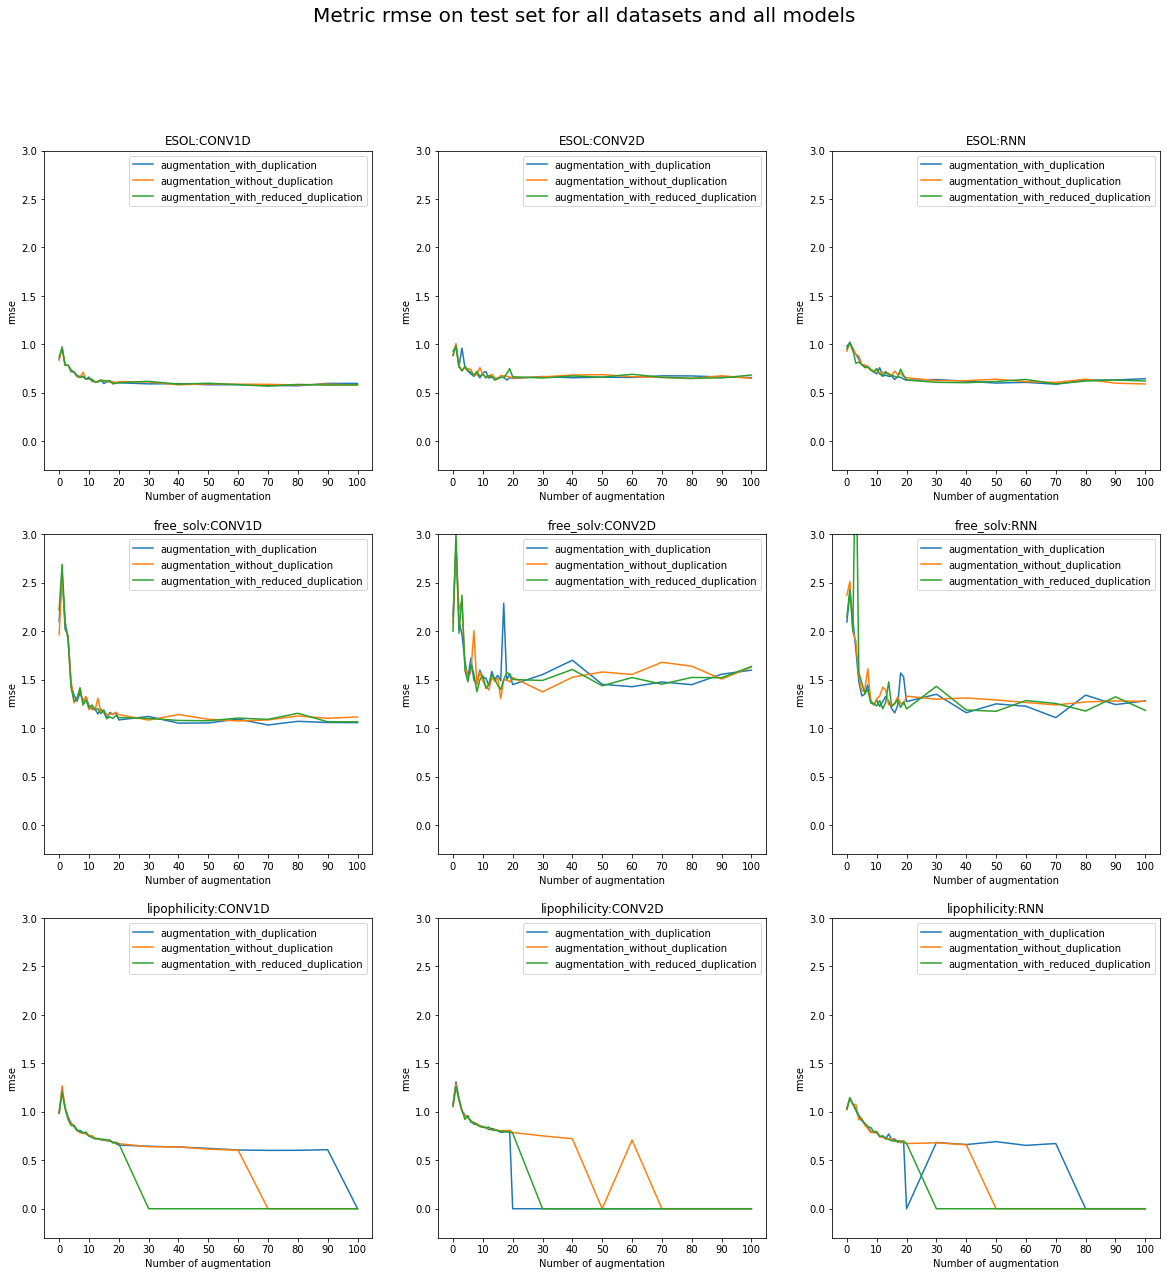

In [5]:
plot_metric("rmse", "test")

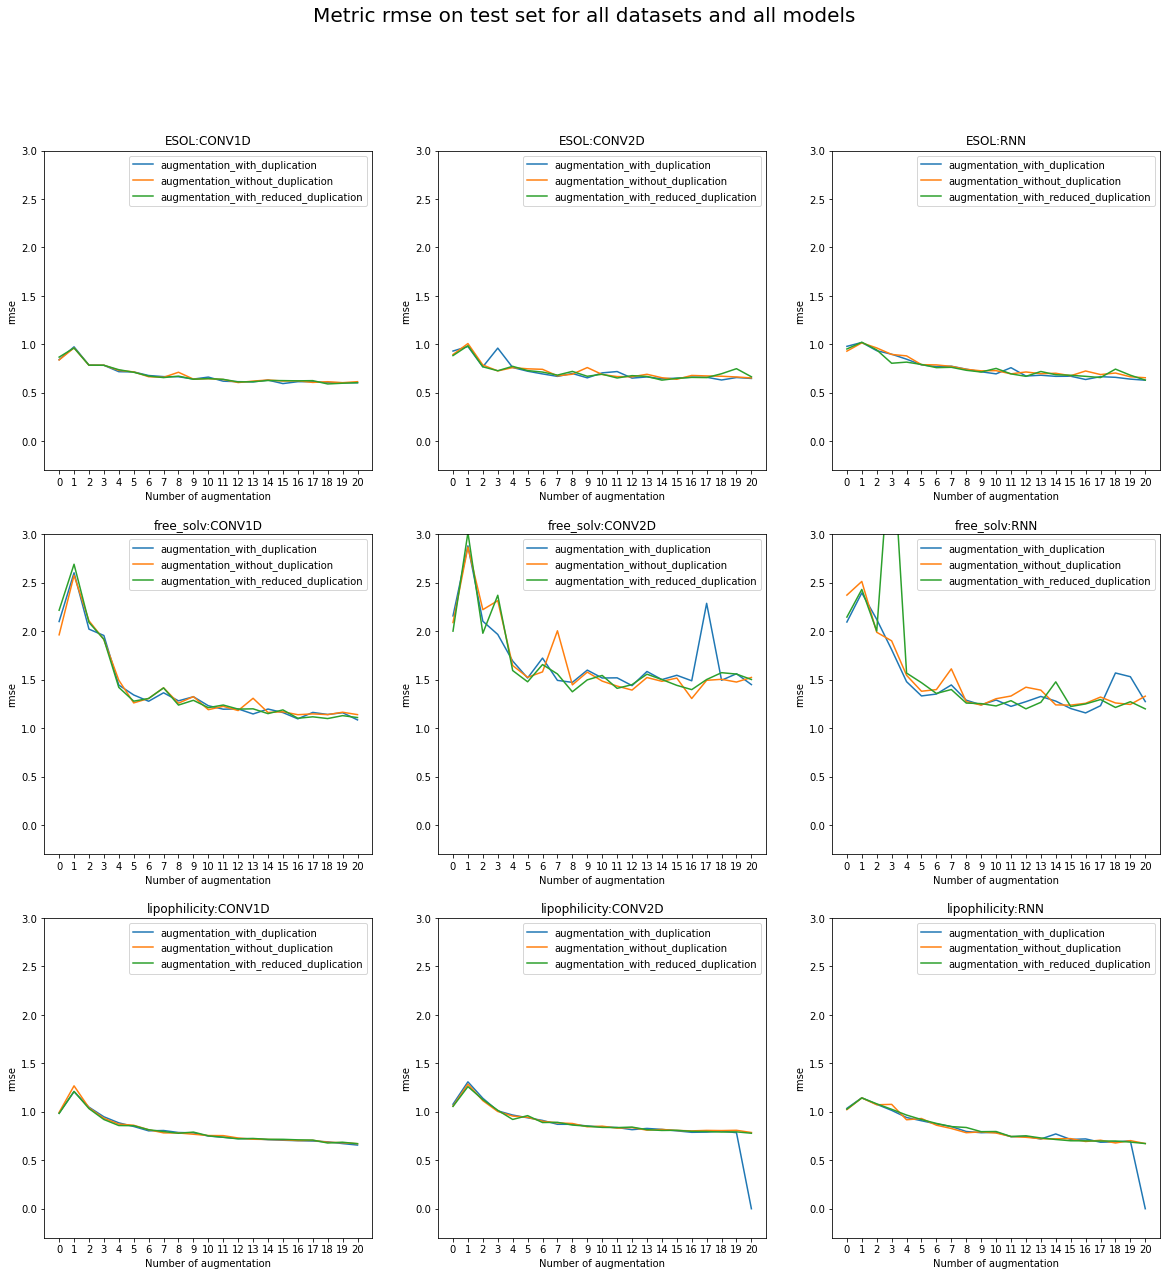

In [6]:
plot_metric("rmse", "test", fine_grid)

### 2. Does the performance (only/strictly) increase with augmentation or does it reach a plateau?

#### Answer

It seems to reach a plateau and it seems that around 10-20, the plateau is reached in most cases.

#### Follow up question:

How about doing a finer augmentation, i.e. instead of
$$
0, 10, 20, ..., 100,
$$
try
$$
0, 1, 2, ..., 20.
$$ 

### 3. What is the best augmentation strategy ?

#### Answer

There isn't one strategy which stands out as being _the_ best. But from a purely numerical point of view, we have:


For ESOL:
- model CONV1D: augmentation_with_reduced_duplication, 70, 0.926
- model CONV2D: augmentation_with_duplication, 20, 0.906
- model RNN: augmentation_with_duplication, 70, 0.921
- model CONV1D: augmentation_maximum_estimation, 0.910

So for ESOL, the best setting is : **model CONV1D: augmentation_with_reduced_duplication, 70, 0.926**

For free_solv:
- model CONV1D: augmentation_with_duplication, 70, 0.935
- model CONV2D: augmentation_without_duplication, 30, 0.885
- model RNN: augmentation_with_duplication, 70, 0.925

For free_solv, the best setting is : **model CONV1D: augmentation_with_duplication, 70, 0.935**


### 4. Can the model learn the inherent symmetry of the molecules using controlled duplication ? (or augmentation with duplication?)

#### Answer

Yes, it seems that the mean prediction error is smaller for symmetric molecules if augmentation used. Analysis to be continued!

### Appendix

#### Canonical VS single random SMILES

From the plot above, it seems that using one random SMILES instead of the canonical SMILES worsens the performance. Why?
It stands out especially in the free_solv case. Let's have a closer look.

In [7]:
TASK = "free_solv"
STRING_ENCODING = "smiles"
TRAIN_AUGMENTATION = 1
TEST_AUGMENTATION = 1
AUGMENTATION_STRATEGY_TRAIN = "augmentation_with_duplication"
AUGMENTATION_STRATEGY_TEST = "augmentation_with_duplication"
ML_MODEL = "CONV1D"

In [8]:
test_data = load_results(TASK,
                         AUGMENTATION_STRATEGY_TRAIN,
                         TRAIN_AUGMENTATION,
                         AUGMENTATION_STRATEGY_TEST,
                         TEST_AUGMENTATION,
                         ML_MODEL,
                         STRING_ENCODING,
                         True)
test_data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
394,-9.40,O=C(O)c1cc(-c2ccc(F)cc2F)ccc1O,[c1(-c2c(F)cc(cc2)F)ccc(c(c1)C(O)=O)O],[c1(-c2c(F)cc(cc2)F)ccc(c(c1)C(O)=O)O],-3.304065,0.0
268,1.23,C1CCCCC1,[C1CCCCC1],[C1CCCCC1],0.645184,0.0
364,-9.28,CS(C)=O,[CS(=O)C],[CS(=O)C],-4.688607,0.0
612,-5.73,O=[N+]([O-])OCCO[N+](=O)[O-],[O(CCO[N+](=O)[O-])[N+](=O)[O-]],[O(CCO[N+](=O)[O-])[N+](=O)[O-]],-14.728643,0.0
370,0.10,ClC(Cl)=C(Cl)Cl,[C(Cl)(=C(Cl)Cl)Cl],[C(L)(=C(L)L)L],1.347437,0.0


In [9]:
test_data["num_heavy_atoms"] = test_data["canonical_\
smiles"].apply(get_num_heavy_atoms)

In [10]:
longer_canonical = 0
for index, row in test_data.iterrows():
    if len(row['canonical_smiles']) > len(row['augmented_smiles'][0]):
        longer_canonical += 1
        print(f"{row['canonical_smiles']} \t\t {len(row['canonical_smiles'])}"
              f"\n{row['augmented_smiles'][0]} \t\t"
              f"{len(row['augmented_smiles'][0])}\n\n")

COP(=O)(OC)[C@@H](O)C(Cl)(Cl)Cl 		 31
COP([C@H](C(Cl)(Cl)Cl)O)(=O)OC 		30


CC[C@@H](O)C(C)C 		 16
CC(C)[C@H](O)CC 		15


Clc1cc(Cl)c(-c2ccccc2)c(Cl)c1 		 29
Clc1cc(cc(c1-c1ccccc1)Cl)Cl 		27




In [11]:
print(f"Out of {test_data.shape[0]} SMILES, "
      f"only {longer_canonical} canonical SMILES "
      f"are longer than the random one and "
      f"branches in the random SMILES are generally more nested.")

Out of 129 SMILES, only 3 canonical SMILES are longer than the random one and branches in the random SMILES are generally more nested.


In [12]:
for index, row in test_data[test_data["num_heavy_atoms"] >= 15].iterrows():
    print(f"{row['canonical_smiles']} \t\t {len(row['canonical_smiles'])}"
          f"\n{row['augmented_smiles'][0]} \t\t "
          f"{len(row['augmented_smiles'][0])}\n\n")

O=C(O)c1cc(-c2ccc(F)cc2F)ccc1O 		 30
c1(-c2c(F)cc(cc2)F)ccc(c(c1)C(O)=O)O 		 36


Clc1ccc(-c2cc(Cl)c(Cl)c(Cl)c2Cl)c(Cl)c1Cl 		 41
c1(Cl)c(ccc(c1Cl)Cl)-c1cc(c(Cl)c(Cl)c1Cl)Cl 		 43


ClC1=C(Cl)[C@]2(Cl)[C@H]3[C@H]4C[C@H]([C@@H]5O[C@@H]54)[C@H]3[C@@]1(Cl)C2(Cl)Cl 		 79
C1([C@@]2(C(Cl)([C@](C=1Cl)([C@H]1[C@H]3C[C@@H]([C@H]12)[C@H]1[C@@H]3O1)Cl)Cl)Cl)Cl 		 83


Nc1cnn(-c2ccccc2)c(=O)c1Cl 		 26
O=c1c(Cl)c(cnn1-c1ccccc1)N 		 26


Clc1ccc2c(c1)Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1O2 		 40
Clc1c(c2c(Oc3c(cc(cc3)Cl)O2)c(c1Cl)Cl)Cl 		 40


CN(C)CCOC(c1ccccc1)c1ccccc1 		 27
c1cccc(c1)C(OCCN(C)C)c1ccccc1 		 29


CC(=O)OCC(COC(C)=O)OC(C)=O 		 26
C(OCC(OC(C)=O)COC(C)=O)(C)=O 		 28


CCCN(CCC)c1c([N+](=O)[O-])cc(C(F)(F)F)cc1[N+](=O)[O-] 		 53
C(CN(CCC)c1c(cc(C(F)(F)F)cc1[N+]([O-])=O)[N+](=O)[O-])C 		 55


Clc1cc(Cl)c(-c2ccccc2)c(Cl)c1 		 29
Clc1cc(cc(c1-c1ccccc1)Cl)Cl 		 27


Clc1cc(-c2c(Cl)cc(Cl)c(Cl)c2Cl)c(Cl)c(Cl)c1Cl 		 45
c1(c(-c2cc(c(Cl)c(Cl)c2Cl)Cl)c(Cl)c(Cl)c(c1)Cl)Cl 		 49


CNC(=O)Oc1cccc2c1OC(C)(C)C2 

#### Time for training

The plot below shows how training time evolves with respect to augmentation.

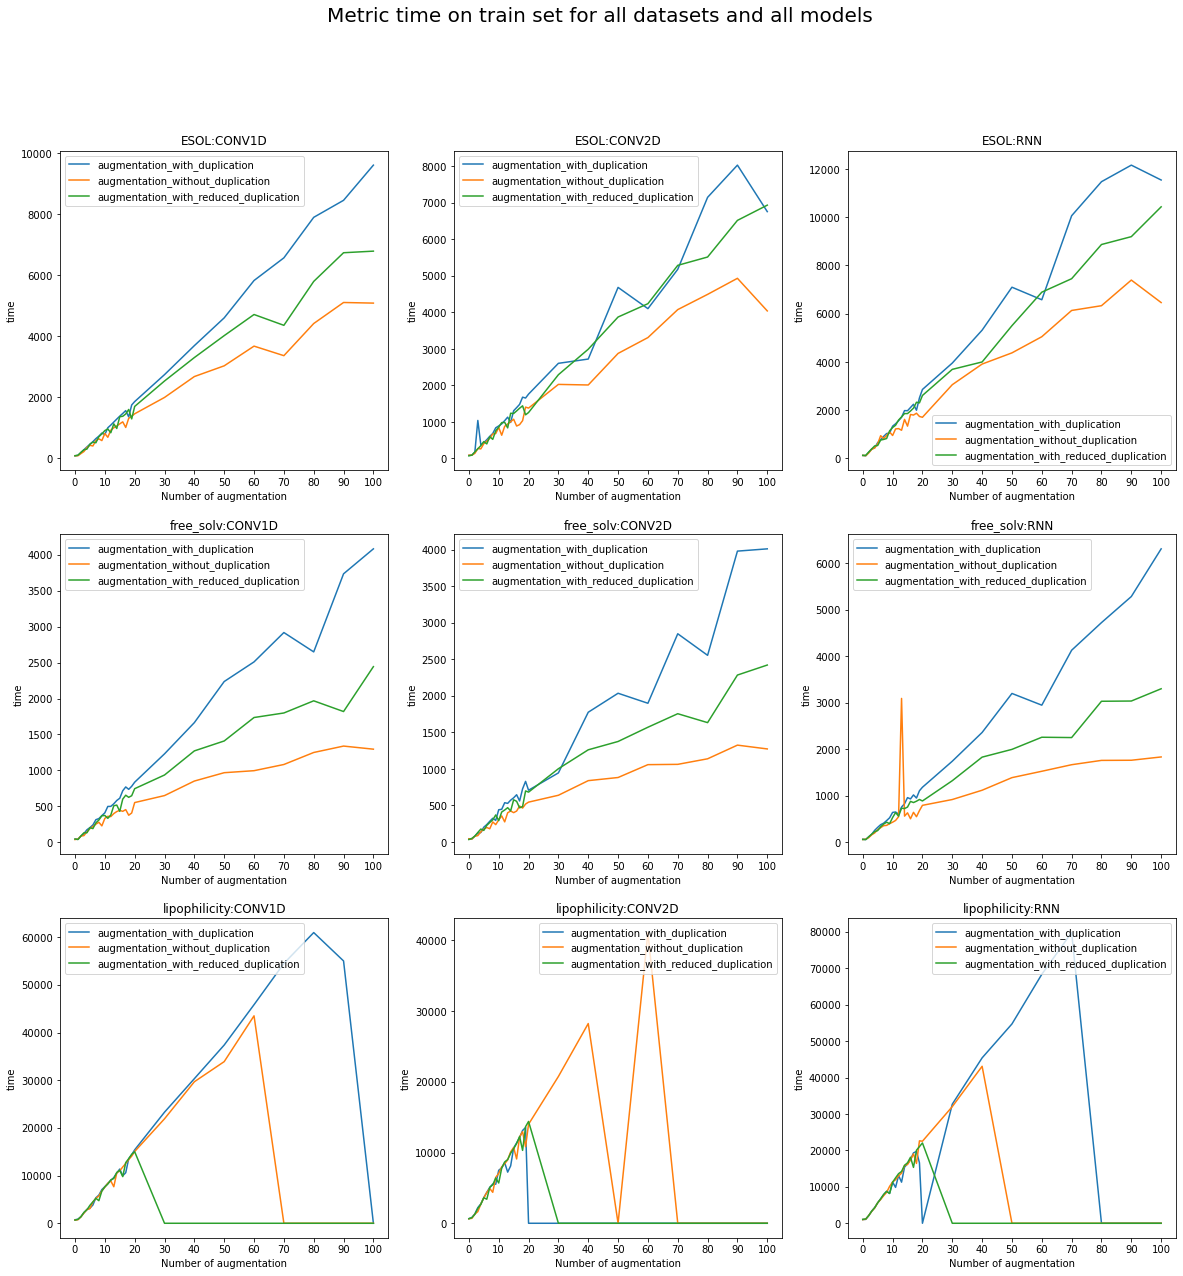

In [13]:
plot_metric("time", "train")